<a href="https://colab.research.google.com/github/sojith29034/Rain-and-Flood-Pred/blob/main_branch/Temp%2C_Rain_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install requests pandas matplotlib tensorflow shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c13d0e10021fd9a8b7d9f26be99a6384a19cb064a68f2bcc90c4ef6709b1a2e9
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import timedelta

<ipython-input-4-058835c86566>:87: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


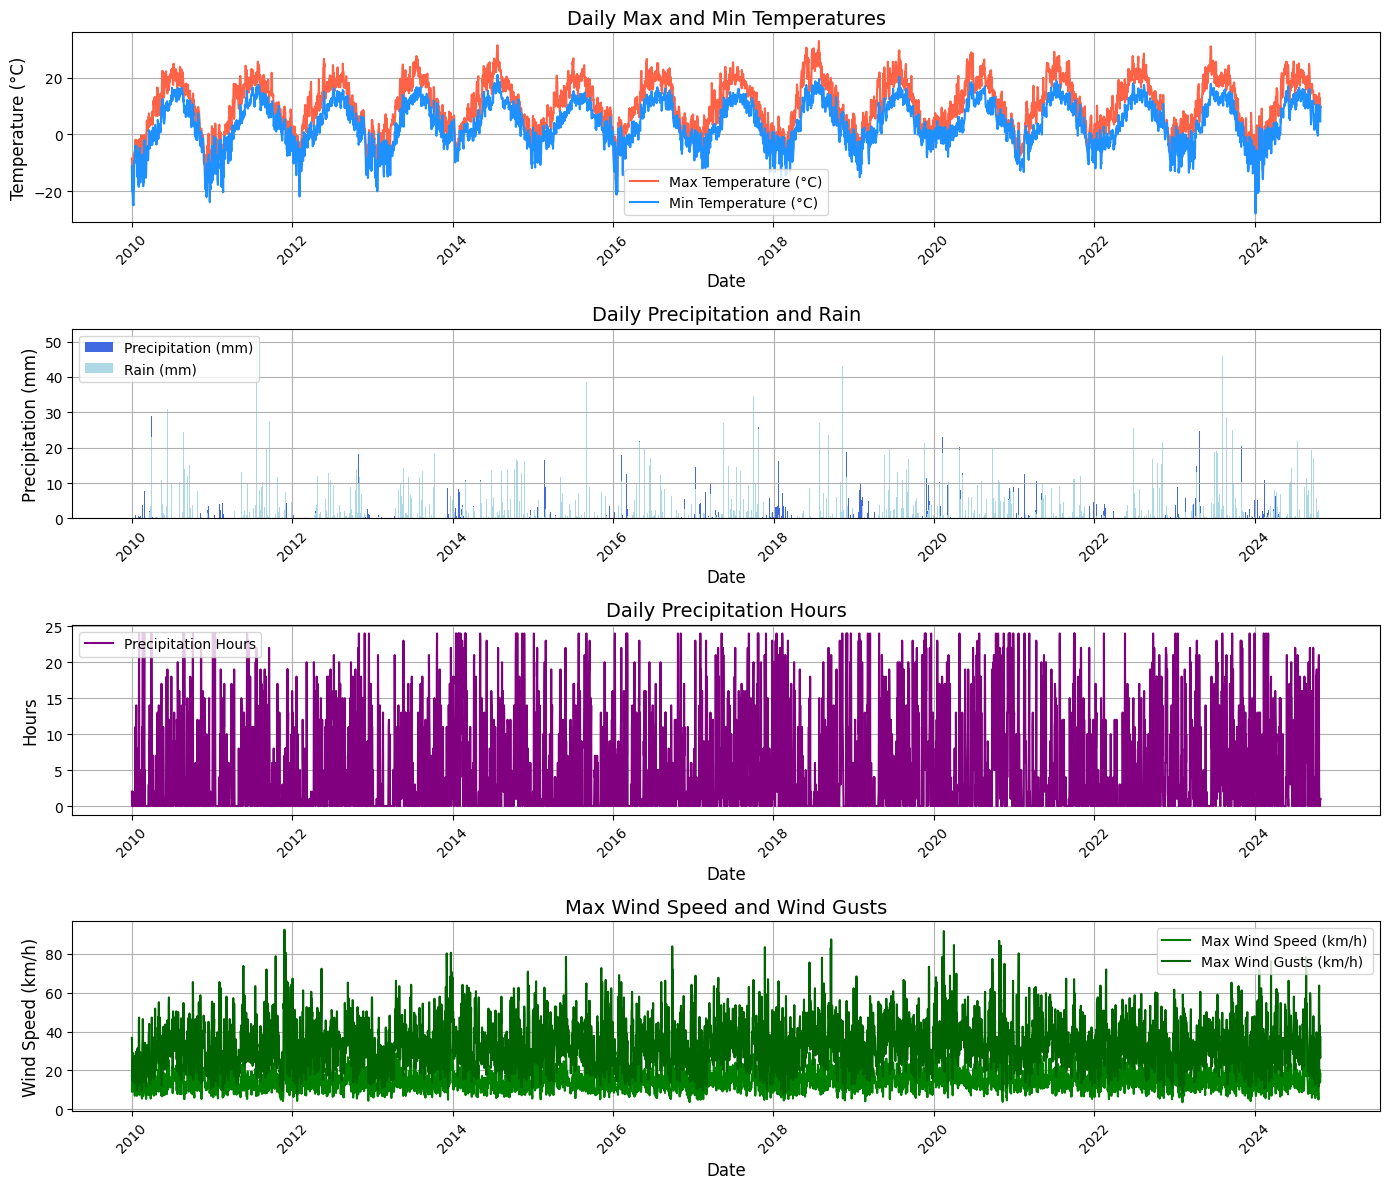

In [ ]:
# Step 1: API Data Fetching
def fetch_weather_data(latitude, longitude, start_date, end_date):
    url = f"https://archive-api.open-meteo.com/v1/archive"
    params = {
      "latitude": latitude,
      "longitude": longitude,
      "start_date": start_date,
      "end_date": end_date,
      "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum", "rain_sum", "precipitation_hours", "wind_speed_10m_max", "wind_gusts_10m_max"],
      "timezone": "GMT"
    }

    # Send a GET request to the API
    response = requests.get(url, params=params)
    data = response.json()

    # Extracting daily data
    daily_data = data["daily"]

    # Create a DataFrame for easier analysis
    df = pd.DataFrame(daily_data)
    df['time'] = pd.to_datetime(df['time'])  # Convert time to datetime
    return df

yesterday = pd.to_datetime("today").date() - timedelta(days=1)

# Fetch data for a sample location (e.g., Oslo, Norway) for January 2020 - October 2023
latitude = 59.91
longitude = 10.75
start_date = "2010-01-01"
end_date = yesterday

# Fetch the weather data
weather_df = fetch_weather_data(latitude, longitude, start_date, end_date)

# Step 2: Data Cleaning and Processing
# Handling missing values (if any)
weather_df.ffill()  # Forward fill to handle missing data

# Step 3: Visualization for all weather parameters
plt.figure(figsize=(14, 12))

# Plot Max and Min Temperature
plt.subplot(4, 1, 1)
plt.plot(weather_df['time'], weather_df['temperature_2m_max'], label='Max Temperature (°C)', color='tomato')
plt.plot(weather_df['time'], weather_df['temperature_2m_min'], label='Min Temperature (°C)', color='dodgerblue')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title('Daily Max and Min Temperatures', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Plot Precipitation Sum and Rain Sum
plt.subplot(4, 1, 2)
plt.bar(weather_df['time'], weather_df['precipitation_sum'], label='Precipitation (mm)', color='royalblue', width=1)
plt.bar(weather_df['time'], weather_df['rain_sum'], label='Rain (mm)', color='lightblue', width=1)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Precipitation (mm)', fontsize=12)
plt.title('Daily Precipitation and Rain', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Plot Precipitation Hours
plt.subplot(4, 1, 3)
plt.plot(weather_df['time'], weather_df['precipitation_hours'], label='Precipitation Hours', color='purple')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Hours', fontsize=12)
plt.title('Daily Precipitation Hours', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Plot Wind Speed and Gusts
plt.subplot(4, 1, 4)
plt.plot(weather_df['time'], weather_df['wind_speed_10m_max'], label='Max Wind Speed (km/h)', color='green')
plt.plot(weather_df['time'], weather_df['wind_gusts_10m_max'], label='Max Wind Gusts (km/h)', color='darkgreen')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Wind Speed (km/h)', fontsize=12)
plt.title('Max Wind Speed and Wind Gusts', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Step 2: Data Preprocessing
weather_df['rain_today'] = (weather_df['rain_sum'] > 0).astype(int)

# Features (X) and target (y)
X = weather_df[['temperature_2m_max', 'temperature_2m_min', 'precipitation_hours', 'wind_speed_10m_max', 'wind_gusts_10m_max']]
y = weather_df['rain_today']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the feature data (important for SVM and Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Apply Machine Learning Models

# Initialize a dictionary to store the evaluation metrics
model_metrics = {}

# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)
log_reg_pred = log_reg.predict(X_test_scaled)

# Store metrics
model_metrics['Logistic Regression'] = {
    'Accuracy': accuracy_score(y_test, log_reg_pred),
    'Precision': precision_score(y_test, log_reg_pred),
    'Recall': recall_score(y_test, log_reg_pred),
    'F1 Score': f1_score(y_test, log_reg_pred)
}

# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)  # Random Forest doesn't need scaling
rf_pred = rf_clf.predict(X_test)

# Store metrics
model_metrics['Random Forest'] = {
    'Accuracy': accuracy_score(y_test, rf_pred),
    'Precision': precision_score(y_test, rf_pred),
    'Recall': recall_score(y_test, rf_pred),
    'F1 Score': f1_score(y_test, rf_pred)
}

# Support Vector Classifier (SVC)
svc_clf = SVC(random_state=42)
svc_clf.fit(X_train_scaled, y_train)
svc_pred = svc_clf.predict(X_test_scaled)

# Store metrics
model_metrics['Support Vector Classifier'] = {
    'Accuracy': accuracy_score(y_test, svc_pred),
    'Precision': precision_score(y_test, svc_pred),
    'Recall': recall_score(y_test, svc_pred),
    'F1 Score': f1_score(y_test, svc_pred)
}

# Step 4: Prepare Data for LSTM
# Reshape the data to 3D
X_reshaped = X.values.reshape((X.shape[0], 1, X.shape[1]))  # (samples, time steps, features)
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Step 5: Build and Train the LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))  # Regularization to prevent overfitting
lstm_model.add(Dense(1, activation='sigmoid'))  # Binary classification

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=0)

# Evaluate LSTM Model
lstm_pred = (lstm_model.predict(X_test_lstm) > 0.5).astype(int)  # Thresholding for binary output

# Store metrics
model_metrics['LSTM'] = {
    'Accuracy': accuracy_score(y_test_lstm, lstm_pred),
    'Precision': precision_score(y_test_lstm, lstm_pred),
    'Recall': recall_score(y_test_lstm, lstm_pred),
    'F1 Score': f1_score(y_test_lstm, lstm_pred)
}

# Step 6: Create a cumulative table for comparison
metrics_df = pd.DataFrame(model_metrics).T

# Display the metrics table
print(metrics_df)

# Step 7: Identify the best model based on F1 Score
best_model = metrics_df['F1 Score'].idxmax()
print(f"The best model based on F1 Score is: {best_model}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
                           Accuracy  Precision    Recall  F1 Score
Logistic Regression        0.843029   0.874429  0.769076  0.818376
Random Forest              0.967682   0.971487  0.957831  0.964611
Support Vector Classifier  0.950139   0.972340  0.917671  0.944215
LSTM                       0.969529   0.975460  0.957831  0.966565
The best model based on F1 Score is: LSTM


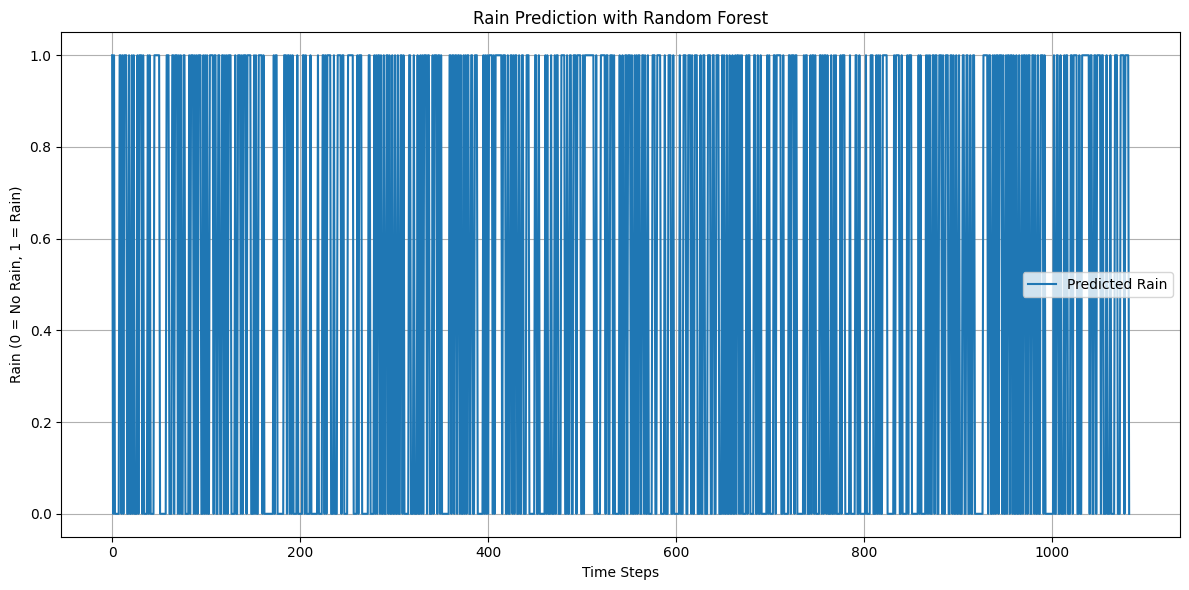

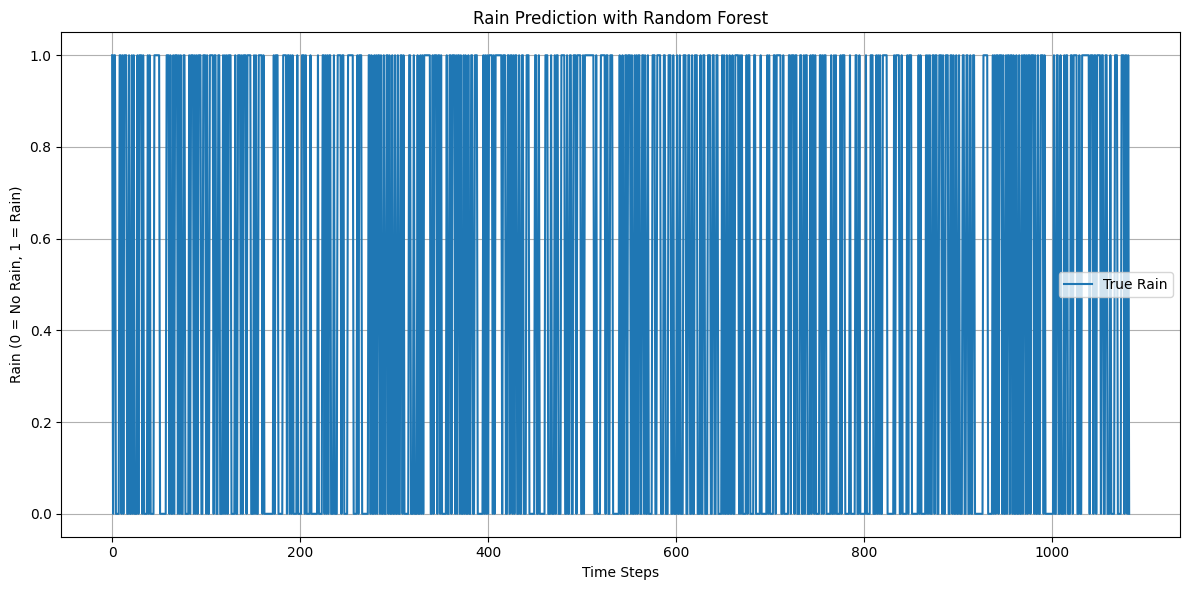

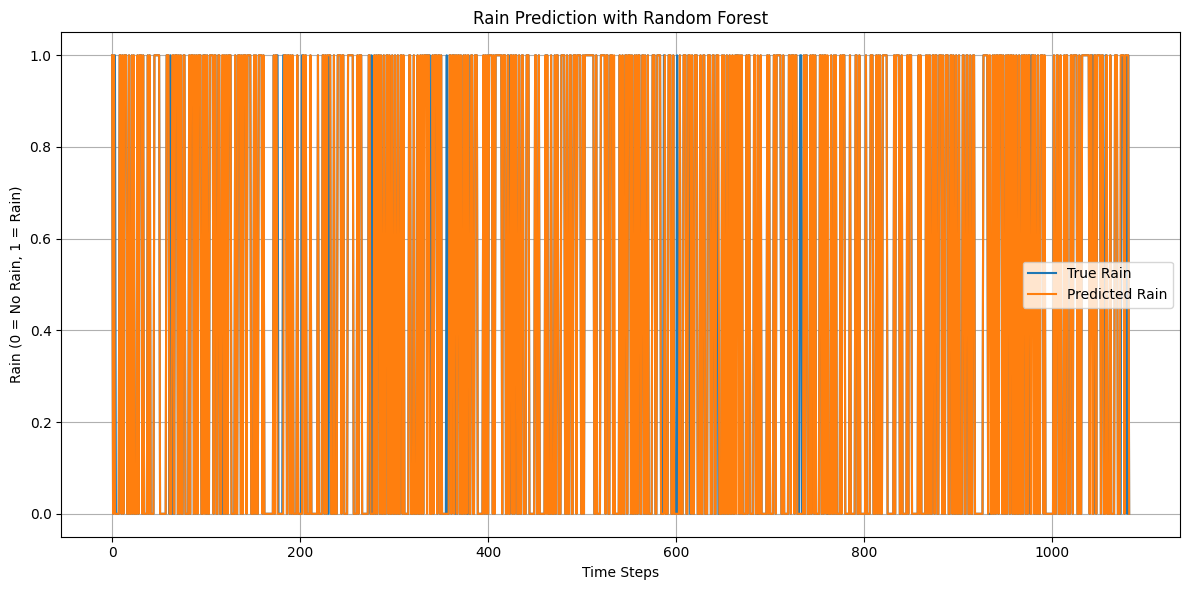

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(rf_pred, label='Predicted Rain')
plt.title('Rain Prediction with Random Forest')
plt.xlabel('Time Steps')
plt.ylabel('Rain (0 = No Rain, 1 = Rain)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Rain')
plt.title('Rain Prediction with Random Forest')
plt.xlabel('Time Steps')
plt.ylabel('Rain (0 = No Rain, 1 = Rain)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Rain')
plt.plot(rf_pred, label='Predicted Rain')
plt.title('Rain Prediction with Random Forest')
plt.xlabel('Time Steps')
plt.ylabel('Rain (0 = No Rain, 1 = Rain)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Shape of SHAP values for class 0 (No Rain): (5, 2)
Shape of SHAP values for class 1 (Rain): (5, 2)


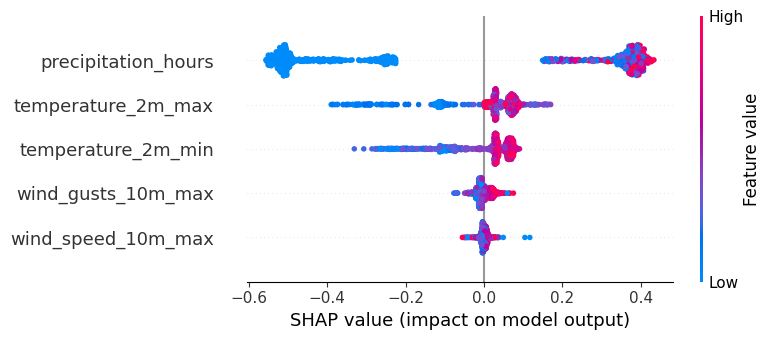

NameError: name 'LimeTabularExplainer' is not defined

In [ ]:
# Step 5: SHAP Analysis
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(rf_clf)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Check the shape of the SHAP values
print(f"Shape of SHAP values for class 0 (No Rain): {shap_values[0].shape}")
print(f"Shape of SHAP values for class 1 (Rain): {shap_values[1].shape}")

# Plot SHAP summary for the positive class (rain)
# Access the SHAP values for the "Rain" class (1)
shap.summary_plot(shap_values[:, :, 1], X_test, feature_names=X.columns)

# Step 6: LIME Analysis
# Create a LIME explainer
lime_explainer = LimeTabularExplainer(X_train.values,
                                       feature_names=X.columns,
                                       class_names=['No Rain', 'Rain'],
                                       mode='classification')

# Explain the prediction for a specific instance
instance_index = 0  # Change this index for different instances
lime_exp = lime_explainer.explain_instance(X_test.values[instance_index],
                                            rf_clf.predict_proba,
                                            num_features=5)

# Visualize the LIME explanation
lime_exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
# Check the shape of X_train and X_test
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(rf_clf)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Check SHAP values for both classes
print(f"Shape of SHAP values for class 0 (No Rain): {shap_values[0].shape}")
print(f"Shape of SHAP values for class 1 (Rain): {shap_values[1].shape}")

# Plot SHAP summary for the positive class (rain)
shap.summary_plot(shap_values[1], X_test, feature_names=X.columns)